In [2]:
import numpy as np
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

import chugunov_indicator as chug

In [3]:
def D_T_setup(ax) -> None:
    """Sets up the axes of a D-T graph."""

    ax.set_xlabel("$T$")
    ax.set_ylabel("$\\rho$")

    ax.set_xscale("log")
    ax.set_yscale("log")

def D_T_colorgraph(T, D, y, fig, ax) -> tuple:
    """Creates a colormesh of y-data on a D-T graph."""

    D_T_setup(ax)

    cb = ax.pcolormesh(T, D, y)
    cbar = fig.colorbar(cb)

    return cb, cbar

def clip(x: np.ndarray, maximum: float = 1.01) -> np.ndarray:
    return np.where(x > maximum, maximum, x)

Consider the data from `introduction.ipynb` once more.

In [4]:
kwargs = {
    'abar': 4.028776983649795,
    'zbar': 2.0143884920095214,
    'z2bar': 4.12949645671095,
    'z1': 2,
    'a1': 4,
    'z2': 6,
    'a2': 12
}

In [5]:
D_, T_ = np.logspace([7, 9.35], [-4, 8], num=100).T

T, D = np.meshgrid(T_, D_)

In [6]:
F = chug.chugunov_2009.chugunov_2009(T=T, D=D, **kwargs)

We wish to perform a fit for the border curve of the form
$$
    \rho(T) = 10^{-c} T^k,
$$
where $c$ and $k$ depend on the properties of the composition and the screening pair.

To isolate the line, we consider a narrow band of the form $1.005 < F < 1.01$.

In [7]:
border = (1.005 < F) & (F < 1.01)

T_border, D_border = T[border], D[border]

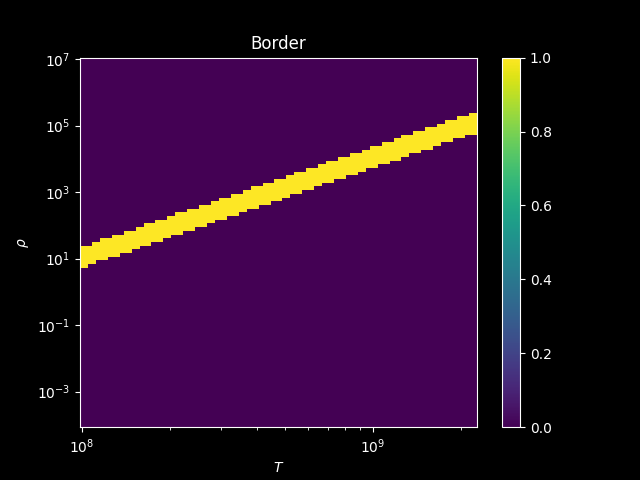

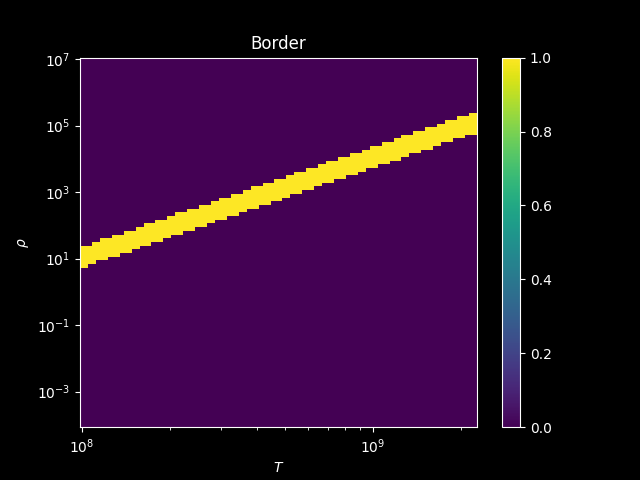

In [8]:
fig0, ax0 = plt.subplots()

cb, cbar = D_T_colorgraph(T, D, border.astype(int), fig0, ax0)

ax0.set_title("Border")



fig0.show()

With this, we make the ansatz that $k = 3$, leaving $c$ (the negative $y$-intercept) as the only fit parameter:

In [9]:
c, var_c = chug.fitting._intercept_from_border(T_border, D_border, return_pcov=True)
c, np.sqrt(var_c)

(22.928079145087864, 0.007578293500499721)

This gives $c \approx 23$. The uncertainty is quite low, implying that our ansatz $k = 3$ is very accurate. As we will see soon, $k = 3$ and $\sigma_c \ll c$ actually holds for all possible values of $\bar{A}, \bar{Z}, \overline{Z^2}, Z_1, A_1, Z_2, A_2$.

This 

0

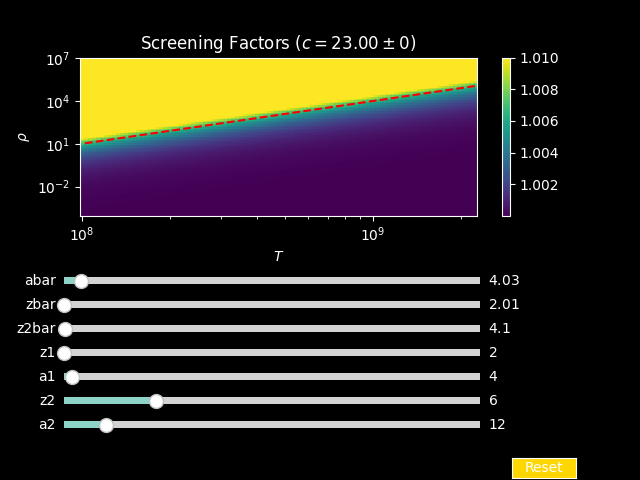

In [12]:
%matplotlib widget

fig1, ax1 = plt.subplots()
fig1.subplots_adjust(bottom=0.55)

# Slider dictionaries
ax_sliders = {}
sliders = {}
maxes = {
    "abar": 52.43965444432472,
    "zbar": 26.223830930940498,
    "z2bar": 713.3104742534674,
    "z1": 20,
    "z2": 20,
    "a1": 100,
    "a2": 100 
}

# Create initial plots
c, var_c = 23, 0
cb, cbar = D_T_colorgraph(T, D, clip(F), fig1, ax1)

line, = ax1.plot(T_, chug.fitting.border_func(T_, c), linestyle="--", color="red")
ax1.set_title(f"Screening Factors ($c = {c:.2f} \\pm {np.sqrt(var_c):.3g}$)")

# Create function to be called when slider value is changed
def update(val) -> None:
    kwargs_new = {key: sliders[key].val for key in kwargs}
    F_new = chug.chugunov_2009.chugunov_2009(T, D, **kwargs_new)
    cb.set_array(clip(F_new))

    border_new = (1.005 < F_new) & (F_new < 1.01)
    T_border_new, D_border_new = T[border_new], D[border_new]
    (c_new,), ((var_c_new,),) = curve_fit(
        chug.fitting.border_func, T_border_new, D_border_new,
        p0 = (23,), bounds=(12, 36)
    )

    line.set_ydata(chug.fitting.border_func(T_, c_new))
    ax1.set_title(f"Screening Factors ($c = {c_new:.2f} \\pm {np.sqrt(var_c_new):.3g}$)")

for j, key in enumerate(kwargs):
    # Create axes
    ax_sliders[key] = fig1.add_axes([0.1, 0.4 - j*0.05, 0.65, 0.03])
    # Create sliders
    sliders[key] = Slider(ax_sliders[key], key, 2, maxes[key], valinit=kwargs[key])
    # Call update function when slider value is changed
    sliders[key].on_changed(update)

# Create axes for reset button and create button
resetax = fig1.add_axes([0.8, 0.005, 0.1, 0.04])
button = Button(resetax, 'Reset', color='gold',
                hovercolor='skyblue')
 
# Create a function resetSlider to set slider to
# initial values when Reset button is clicked
 
def resetSlider(event) -> None:
    for slider in sliders.values():
        slider.reset()
 
# Call resetSlider function when clicked on reset button
button.on_clicked(resetSlider)

# Show graph
#fig1.show()

Based on the above, it would seem that changes in $A_1, A_2$ have no impact on the location of this line. And as stated before, it seems that the relations $\sigma_c \ll c$ and $\rho_b \propto T^3$ hold in general.

From there, the line's height significantly increases with $\bar{A}$, significantly decreases with $\overline{Z^2}, Z_1, Z_2$, and very weakly decreases with $\bar{Z}$. Note that decreases in the line's height correspond to screening being more important.

Physically, this makes sense - stronger charges $\overline{Z^2}, Z_1, Z_2$ will cause more screening, while a composition with increased mass $\bar{A}$ will resist that screening more easily.